# Model Explainability Analysis

This notebook provides explainability analysis for the multimodal fusion model using two complementary techniques: Grad-CAM (visualizes which regions of satellite images the model focuses on) and SHAP (quantifies the contribution of each tabular feature). Results are saved to the `explainability_results/` directory.



Loaded 200 IDs from final_submission.csv
Loading Data...
Loading Model...
Generating explanations for 200 IDs...

--- Generating Grad-CAM ---

--- Generating Enhanced Grad-CAM for 200 IDs ---
ID 2591820310: Raw CAM Range [0.000000, 0.000000]


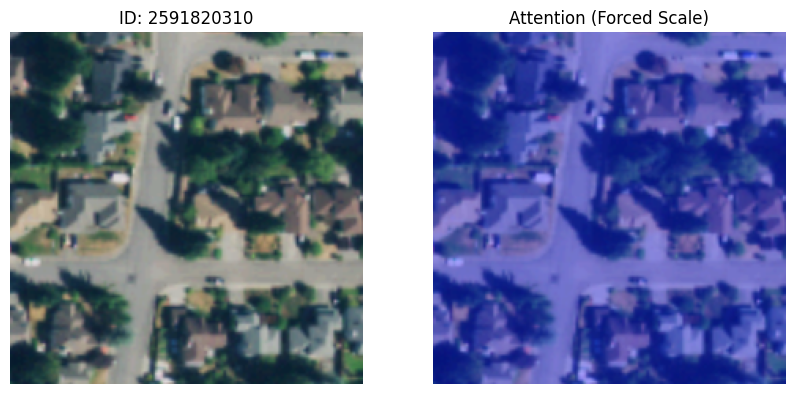

ID 7974200820: Raw CAM Range [0.000000, 0.000000]


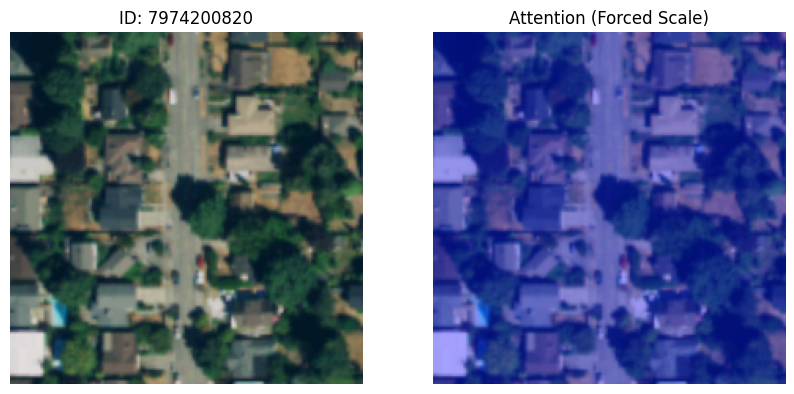

ID 7701450110: Raw CAM Range [0.000000, 0.000000]


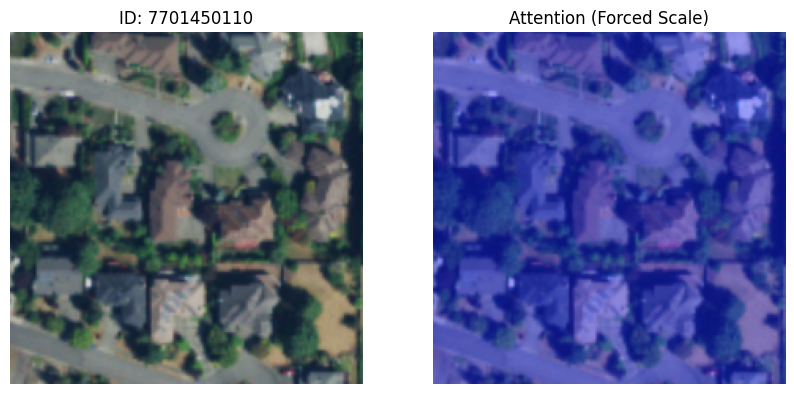

ID 9522300010: Raw CAM Range [0.000000, 0.000000]
ID 9510861140: Raw CAM Range [0.000000, 0.000000]
ID 1761300310: Raw CAM Range [0.000000, 0.000000]
ID 7732410120: Raw CAM Range [0.000000, 0.000000]
ID 7010701383: Raw CAM Range [0.000000, 0.000000]
ID 291310170: Raw CAM Range [0.000000, 0.000000]
ID 4232901990: Raw CAM Range [0.000000, 0.000000]
ID 6840701125: Raw CAM Range [0.000000, 0.000000]
ID 3971700580: Raw CAM Range [0.000000, 0.000000]
ID 4202400078: Raw CAM Range [0.000000, 0.000000]
ID 4202400078: Raw CAM Range [0.000000, 0.000000]
ID 4202400078: Raw CAM Range [0.000000, 0.000000]
ID 4202400078: Raw CAM Range [0.000000, 0.000000]
ID 4202400078: Raw CAM Range [0.000000, 0.000000]
ID 4202400078: Raw CAM Range [0.000000, 0.000000]
ID 4202400078: Raw CAM Range [0.000000, 0.000000]
ID 4202400078: Raw CAM Range [0.000000, 0.000000]
ID 6064800090: Raw CAM Range [0.000000, 0.000000]
ID 2626119028: Raw CAM Range [0.000000, 0.000000]
ID 3303980660: Raw CAM Range [0.000000, 0.000000]
I

C:\Users\Abhi\AppData\Local\Temp\ipykernel_9440\286557591.py:342: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(vals, target_tabs.cpu().detach().numpy(), feature_names=feature_names)


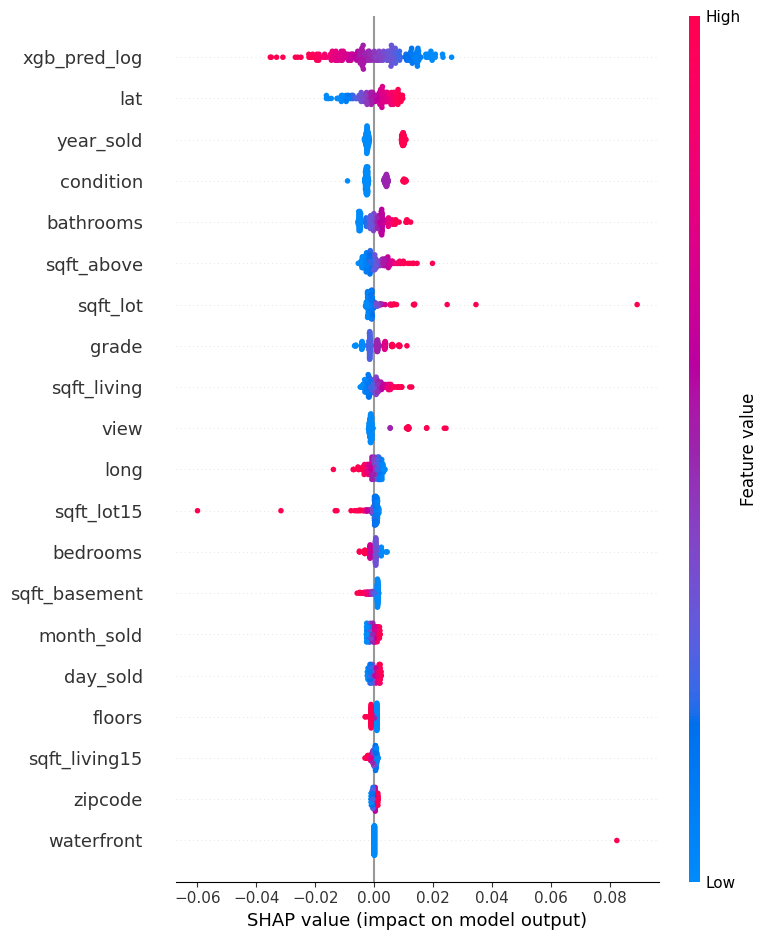

<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms 
import rasterio
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import shap
from tqdm import tqdm

# --- CONFIG ---
TEST_FEATURES_FILE = 'test_tabular.csv' 
XGB_TEST_FILE = 'xg_boost_test.csv'
IMG_DIR = 'naip_images/test_224'
MODEL_SAVE_PATH = 'sota_fusion_best.pth'
SUBMISSION_FILE = 'final_submission.csv'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- USER INPUT: LOAD TARGET IDs ---
try:
    submission_df = pd.read_csv(SUBMISSION_FILE)
    # Take the first 50 IDs to explain
    TARGET_IDS = submission_df['id'].head(200).tolist()
    print(f"Loaded {len(TARGET_IDS)} IDs from {SUBMISSION_FILE}")
except FileNotFoundError:
    print(f"Error: {SUBMISSION_FILE} not found. Please provide manual IDs.")
    TARGET_IDS = [2591820310] # Fallback

# Output Directory
os.makedirs("explainability_results", exist_ok=True)

# ==========================================
# 1. PREPROCESSING (Must Match Training)
# ==========================================
def preprocess_tabular_features(df):
    df = df.copy()
    
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df['year_sold'] = df['date'].dt.year
        df['month_sold'] = df['date'].dt.month
        df['day_sold'] = df['date'].dt.day
    
    ref_year = 2025
    if 'yr_built' in df.columns:
        df['house_age'] = ref_year - df['yr_built']
        
    if 'yr_renovated' in df.columns:
        df['was_renovated'] = (df['yr_renovated'] > 0).astype(int)
        last_update = df['yr_renovated'].where(df['yr_renovated'] != 0, df['yr_built'])
        df['years_since_update'] = ref_year - last_update

    # DROP RAW COLUMNS (Fixes feature size mismatch)
    cols_to_drop = ['yr_built', 'yr_renovated']
    df = df.drop(columns=cols_to_drop, errors='ignore')

    return df

# ==========================================
# 2. DATASET (Inference Mode - No Targets)
# ==========================================
class TestMultimodalDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir
        
        # --- FEATURE ENGINEERING ---
        if 'xg_boost_price' in self.df.columns:
             self.df['xgb_pred_log'] = np.log(self.df['xg_boost_price'])
        else:
             print("Warning: 'xg_boost_price' missing. Setting xgb_pred_log to 0.")
             self.df['xgb_pred_log'] = 0.0

        excluded_cols = [
            'id', 'date', 'price', 'log_price', 'price_pred_xgb', 'xg_boost_price', 
            'residual', 'residual_log', 'target_residual', 'abs_residual',
            'error_category', 'alpha', 'log_price_pred', 'log_xgb', 'predicted_price'
        ]
        
        self.features = [c for c in self.df.columns if c not in excluded_cols]
        if 'xgb_pred_log' not in self.features:
            self.features.append('xgb_pred_log')

        self.tab_data = self.df[self.features].values.astype(np.float32)
        self.tab_mean = self.tab_data.mean(axis=0)
        self.tab_std = self.tab_data.std(axis=0) + 1e-6
        self.tab_data = (self.tab_data - self.tab_mean) / self.tab_std
        
        self.ids = self.df['id'].values
        
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406, 0.485], std=[0.229, 0.224, 0.225, 0.229]
        )

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path = os.path.join(self.img_dir, f"{img_id}.tif")
        try:
            with rasterio.open(img_path) as src:
                image = src.read([1, 2, 3, 4]) 
                image = torch.from_numpy(image).float()
                if image.shape[1] != 224:
                        image = torch.nn.functional.interpolate(
                        image.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
                    ).squeeze(0)
        except:
            image = torch.zeros((4, 224, 224))

        image = image / 255.0  
        image = self.normalize(image)
        tab = torch.tensor(self.tab_data[idx], dtype=torch.float32)
        
        # Return dummy target (0.0) since we are in Inference
        return image, tab, torch.tensor(0.0), img_id

# ==========================================
# 3. MODEL (Concatenation Architecture)
# ==========================================
class FusionModel(nn.Module):
    def __init__(self, tab_input_dim):
        super(FusionModel, self).__init__()
        self.cnn = models.resnet50(weights=None)
        
        original_weights = self.cnn.conv1.weight.data
        new_conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.cnn.conv1 = new_conv1
        self.cnn.fc = nn.Identity() 

        self.vis_compression = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.tab_dim = tab_input_dim
        self.head = nn.Linear(64 + self.tab_dim, 1)

    def forward(self, img, tab):
        vis_feat = self.cnn(img)              
        vis_feat = self.vis_compression(vis_feat) 
        combined = torch.cat((vis_feat, tab), dim=1) 
        return self.head(combined).squeeze()

# ==========================================
# 4. LOAD DATA & MODEL
# ==========================================
print("Loading Data...")
test_df = pd.read_csv(TEST_FEATURES_FILE)

try:
    xgb_df = pd.read_csv(XGB_TEST_FILE)
    if 'price' in xgb_df.columns:
        xgb_df = xgb_df.rename(columns={'price': 'xg_boost_price'})
    test_df = pd.merge(test_df, xgb_df[['id', 'xg_boost_price']], on='id', how='left')
except Exception as e:
    print(f"Warning: Could not load XGB predictions: {e}")
    test_df['xg_boost_price'] = 1.0 

test_df = preprocess_tabular_features(test_df)
dataset = TestMultimodalDataset(test_df, IMG_DIR)

print("Loading Model...")
model = FusionModel(tab_input_dim=len(dataset.features))
# weights_only=False ensures backward compatibility
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE, weights_only=False))
model.to(DEVICE)
model.eval()

# ==========================================
# 5. PREPARE INDICES
# ==========================================
valid_indices = []
found_ids = []

for tid in TARGET_IDS:
    matches = test_df.index[test_df['id'] == tid].tolist()
    if len(matches) > 0:
        valid_indices.append(matches[0])
        found_ids.append(tid)
    else:
        print(f"Warning: ID {tid} not found. Skipping.")

if len(valid_indices) == 0:
    raise ValueError("None of the provided TARGET_IDS were found.")

print(f"Generating explanations for {len(found_ids)} IDs...")

# ==========================================
# 6. GRAD-CAM (With Shape Fixes)
# ==========================================
print("\n--- Generating Grad-CAM ---")

class ImageAttentionWrapper(nn.Module):
    def __init__(self, model, fixed_tab_data):
        super().__init__()
        self.model = model
        self.fixed_tab = fixed_tab_data
        
    def forward(self, x):
        # 1. Run Model
        output = self.model(x, self.fixed_tab)
 
        if output.ndim == 0:
            return output.unsqueeze(0).unsqueeze(1)
        elif output.ndim == 1:
            return output.unsqueeze(1)
            
        return output

def unnorm_rgb(tensor):
    img = tensor.cpu().numpy()[:3, :, :] 
    img = np.transpose(img, (1, 2, 0))   
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    
    return np.clip(img, 0, 1).astype(np.float32)

target_layer = [model.cnn.layer4[-1]]

# ==========================================
# ROBUST VISUALIZATION LOOP (Force Contrast)
# ==========================================
print(f"\n--- Generating Enhanced Grad-CAM for {len(found_ids)} IDs ---")

for i, (idx, tid) in enumerate(zip(valid_indices, found_ids)):
    img, tab, _, _ = dataset[idx]
    
    img_tensor = img.unsqueeze(0).to(DEVICE)
    tab_tensor = tab.unsqueeze(0).to(DEVICE)
    
    wrapper = ImageAttentionWrapper(model, tab_tensor)
    cam = GradCAM(model=wrapper, target_layers=target_layer)
    targets = [ClassifierOutputTarget(0)]
    
    # Generate Raw CAM
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)[0, :]
    
    # --- DIAGNOSTIC PRINT ---
    cam_min, cam_max = grayscale_cam.min(), grayscale_cam.max()
    print(f"ID {tid}: Raw CAM Range [{cam_min:.6f}, {cam_max:.6f}]")
    
    # --- FORCE CONTRAST SCALING ---
    if cam_max == 0:

        visualization = unnorm_rgb(img)
        title_text = "DEAD SIGNAL (Model ignored image)"
    else:

        grayscale_cam = (grayscale_cam - cam_min) / (cam_max - cam_min + 1e-8)
        
        rgb_img = unnorm_rgb(img)
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        title_text = f"Attention (Forced Scale)"

    # Save & Plot
    save_path = f"explainability_results/gradcam_{tid}.png"
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1); plt.imshow(unnorm_rgb(img)); plt.title(f"ID: {tid}")
    plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(visualization); plt.title(title_text)
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight')
    
    # Show first 3 images inline
    if i < 3:
        plt.show()
    plt.close()

print("Grad-CAM generation complete.")

# ==========================================
# 7. SHAP (With Dimension Fixes)
# ==========================================
print("\n--- Running SHAP Analysis ---")

class TabularWrapper(nn.Module):
    def __init__(self, model, fixed_img_feat):
        super().__init__()
        self.model = model
        self.fixed_img_feat = fixed_img_feat
        
    def forward(self, tab):
        combined = torch.cat((self.fixed_img_feat.repeat(tab.shape[0], 1), tab), dim=1)
        return self.model.head(combined)

# 1. Background
bg_inds = np.random.choice(len(dataset), 50, replace=False)
bg_tab = torch.stack([dataset[i][1] for i in bg_inds]).to(DEVICE)

# 2. Average Image Context
with torch.no_grad():
    bg_imgs = torch.stack([dataset[i][0] for i in bg_inds]).to(DEVICE)
    img_feats = model.cnn(bg_imgs)
    img_feats = model.vis_compression(img_feats)
    avg_img_feat = img_feats.mean(dim=0, keepdim=True) 

# 3. Explainer
explainer = shap.GradientExplainer(TabularWrapper(model, avg_img_feat), bg_tab)

# 4. Target Data
target_tabs = torch.stack([dataset[i][1] for i in valid_indices]).to(DEVICE)
target_tabs.requires_grad = True

print(f"Calculating SHAP for {len(target_tabs)} samples...")
shap_values = explainer.shap_values(target_tabs)

# FIX: Handle List Output & Extra Dimensions
if isinstance(shap_values, list):
    vals = shap_values[0]
else:
    vals = shap_values

# Squeeze (1, N, 1) -> (1, N)
if vals.ndim == 3 and vals.shape[-1] == 1:
    vals = np.squeeze(vals, axis=-1)

# 5. Save CSV
feature_names = dataset.features
try:
    shap_df = pd.DataFrame(vals, columns=[f"shap_{f}" for f in feature_names])
    shap_df['id'] = found_ids
    shap_df.to_csv("explainability_results/shap_analysis.csv", index=False)
    print("SHAP values saved to 'explainability_results/shap_analysis.csv'")
except Exception as e:
    print(f"Error saving SHAP CSV: {e}")

# 6. Plot
plt.figure()
shap.summary_plot(vals, target_tabs.cpu().detach().numpy(), feature_names=feature_names)
plt.savefig("explainability_results/shap_summary.png", bbox_inches='tight')
plt.show()